<a href="https://colab.research.google.com/github/juvana81/CODSOFT/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin

# Set plot style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

In [24]:
def load_data(filepath):
    """Load and prepare the Titanic dataset"""
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded data from {filepath}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        # If file upload fails, use sample data or exit
        return None

In [5]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a copy to avoid modifying the original
        X_transformed = X.copy()

        # Create family size feature
        X_transformed['FamilySize'] = X_transformed['SibSp'] + X_transformed['Parch'] + 1

        # Create is alone feature
        X_transformed['IsAlone'] = (X_transformed['FamilySize'] == 1).astype(int)

        # Extract title from name
        X_transformed['Title'] = X_transformed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

        # Group titles
        title_mapping = {
            'Miss': ['Miss', 'Mlle', 'Ms'],
            'Mrs': ['Mrs', 'Mme', 'Lady', 'Countess', 'Dona'],
            'Mr': ['Mr'],
            'Master': ['Master'],
            'Rare': ['Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
        }

        for new_title, old_titles in title_mapping.items():
            X_transformed['Title'] = X_transformed['Title'].replace(old_titles, new_title)

        # Create age groups
        X_transformed['AgeGroup'] = pd.cut(
            X_transformed['Age'],
            bins=[0, 12, 18, 35, 60, 100],
            labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
        )

        # Create fare categories
        X_transformed['FareCategory'] = pd.qcut(
            X_transformed['Fare'],
            q=4,
            labels=['Low', 'Medium', 'High', 'Very High']
        )

        # Create cabin indicator (has cabin info or not)
        X_transformed['HasCabin'] = (~X_transformed['Cabin'].isna()).astype(int)

        # Create embarked_class combination
        X_transformed['Embarked_Class'] = X_transformed['Embarked'].astype(str) + X_transformed['Pclass'].astype(str)

        return X_transformed

In [6]:
def explore_data(df):
    """Perform basic data exploration"""
    print("\n=== DATA EXPLORATION ===")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())

    print("\nData information:")
    df.info()

    print("\nMissing values per column:")
    print(df.isnull().sum())

    print("\nBasic statistics:")
    display(df.describe())

    print(f"\nOverall survival rate: {df['Survived'].mean():.2%}")

    return df

In [7]:
def visualize_data(df):
    """Create visualizations to understand the data"""
    print("\n=== DATA VISUALIZATION ===")

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Survival by Sex
    sns.countplot(ax=axes[0, 0], x='Sex', hue='Survived', data=df)
    axes[0, 0].set_title('Survival by Gender')
    axes[0, 0].legend(title='Survived', labels=['No', 'Yes'])

    # Survival by Passenger Class
    sns.countplot(ax=axes[0, 1], x='Pclass', hue='Survived', data=df)
    axes[0, 1].set_title('Survival by Passenger Class')
    axes[0, 1].legend(title='Survived', labels=['No', 'Yes'])

    # Age distribution
    sns.histplot(ax=axes[1, 0], data=df, x='Age', hue='Survived', multiple='stack', bins=20)
    axes[1, 0].set_title('Age Distribution by Survival Status')

    # Fare distribution
    sns.boxplot(ax=axes[1, 1], x='Pclass', y='Fare', hue='Survived', data=df)
    axes[1, 1].set_title('Fare Distribution by Class and Survival')

    plt.tight_layout()
    plt.show()

    # Additional plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Family size impact
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    sns.barplot(ax=axes[0], x='FamilySize', y='Survived', data=df, ci=None)
    axes[0].set_title('Survival Rate by Family Size')

    # Embarked impact
    sns.countplot(ax=axes[1], x='Embarked', hue='Survived', data=df)
    axes[1].set_title('Survival by Embarkation Port')
    axes[1].legend(title='Survived', labels=['No', 'Yes'])

    plt.tight_layout()
    plt.show()

In [8]:
def prepare_data(df):
    """Prepare data for model training"""
    print("\n=== DATA PREPARATION ===")

    # Apply feature engineering
    feature_engineer = FeatureEngineer()
    df_processed = feature_engineer.transform(df)

    # Split features and target
    X = df_processed.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
    y = df_processed['Survived']

    # Print new features
    print("\nNew features created:")
    for col in X.columns:
        if col not in df.columns:
            print(f"- {col}")

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nTraining set size: {X_train.shape[0]} samples")
    print(f"Validation set size: {X_val.shape[0]} samples")

    return X_train, X_val, y_train, y_val, X.columns


In [16]:
def build_model(X_train, y_train, features):
    """Build and train the model"""
    print("\n=== MODEL BUILDING ===")

    # Define feature groups
    numeric_features = [col for col in features if X_train[col].dtype in ['int64', 'float64'] and col not in ['Pclass']]
    categorical_features = [col for col in features if X_train[col].dtype == 'object' or col == 'Pclass' or 'Group' in col or 'Category' in col]

    print(f"Numeric features: {numeric_features}")
    print(f"Categorical features: {categorical_features}")

    # Define preprocessing for numeric features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the model pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # Define hyperparameters for grid search
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }

    # Perform grid search
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1
    )

    # Train the model
    print("\nTraining model with grid search...")
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    print(f"\nBest parameters: {grid_search.best_params_}")

    return best_model

In [19]:
def evaluate_model(model, X_val, y_val):
    """Evaluate model performance"""
    print("\n=== MODEL EVALUATION ===")

    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Model Accuracy: {accuracy:.2%}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Create confusion matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Did not survive', 'Survived'],
                yticklabels=['Did not survive', 'Survived'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy


In [20]:
def show_feature_importance(model, feature_names):
    """Show feature importance"""
    print("\n=== FEATURE IMPORTANCE ===")

    # Get feature names after preprocessing
    preprocessor = model[0]

    # Get feature importances
    importances = model[-1].feature_importances_

    # Try to get feature names from preprocessor
    try:
        # Extract feature names from the preprocessor's transformers
        feature_names_out = []

        # Process numeric features
        if hasattr(preprocessor, 'transformers_'):
            for name, transformer, features in preprocessor.transformers_:
                if name == 'num':
                    feature_names_out.extend(features)
                elif name == 'cat':
                    if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
                        # Get categorical features after one-hot encoding
                        cat_features = transformer.named_steps['onehot'].get_feature_names_out(features)
                        feature_names_out.extend(cat_features)

        # If feature names were extracted successfully
        if len(feature_names_out) == len(importances):
            # Create a DataFrame for feature importance
            feature_importance = pd.DataFrame({
                'Feature': feature_names_out,
                'Importance': importances
            })
            feature_importance = feature_importance.sort_values('Importance', ascending=False)

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
            plt.title('Top 15 Feature Importance')
            plt.tight_layout()
            plt.show()

            # Print top 10 feature importances
            print("\nTop 10 most important features:")
            display(feature_importance.head(10))
        else:
            print("Feature names and importances length mismatch")
    except Exception as e:
        print(f"Error extracting feature names: {e}")

In [21]:
def predict_survival(model, passenger_data):
    """Make predictions for new passengers"""
    print("\n=== PREDICTION FOR NEW PASSENGERS ===")

    # Process passenger data
    feature_engineer = FeatureEngineer()
    processed_data = feature_engineer.transform(passenger_data)

    # Make prediction
    prediction = model.predict(processed_data)
    prediction_proba = model.predict_proba(processed_data)

    # Display results
    print("\nPrediction Results:")
    results = pd.DataFrame({
        'Passenger': range(1, len(passenger_data) + 1),
        'Prediction': ['Survived' if p == 1 else 'Did not survive' for p in prediction],
        'Survival Probability': [f"{p:.2%}" for p in prediction_proba[:, 1]]
    })

    display(results)

    return prediction, prediction_proba



=== TITANIC SURVIVAL PREDICTION ===


Saving Titanic-Dataset.csv to Titanic-Dataset (1).csv
Successfully loaded data from Titanic-Dataset (1).csv

=== DATA EXPLORATION ===
Dataset shape: (891, 12)

First 5 rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin  

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Overall survival rate: 38.38%

=== DATA VISUALIZATION ===


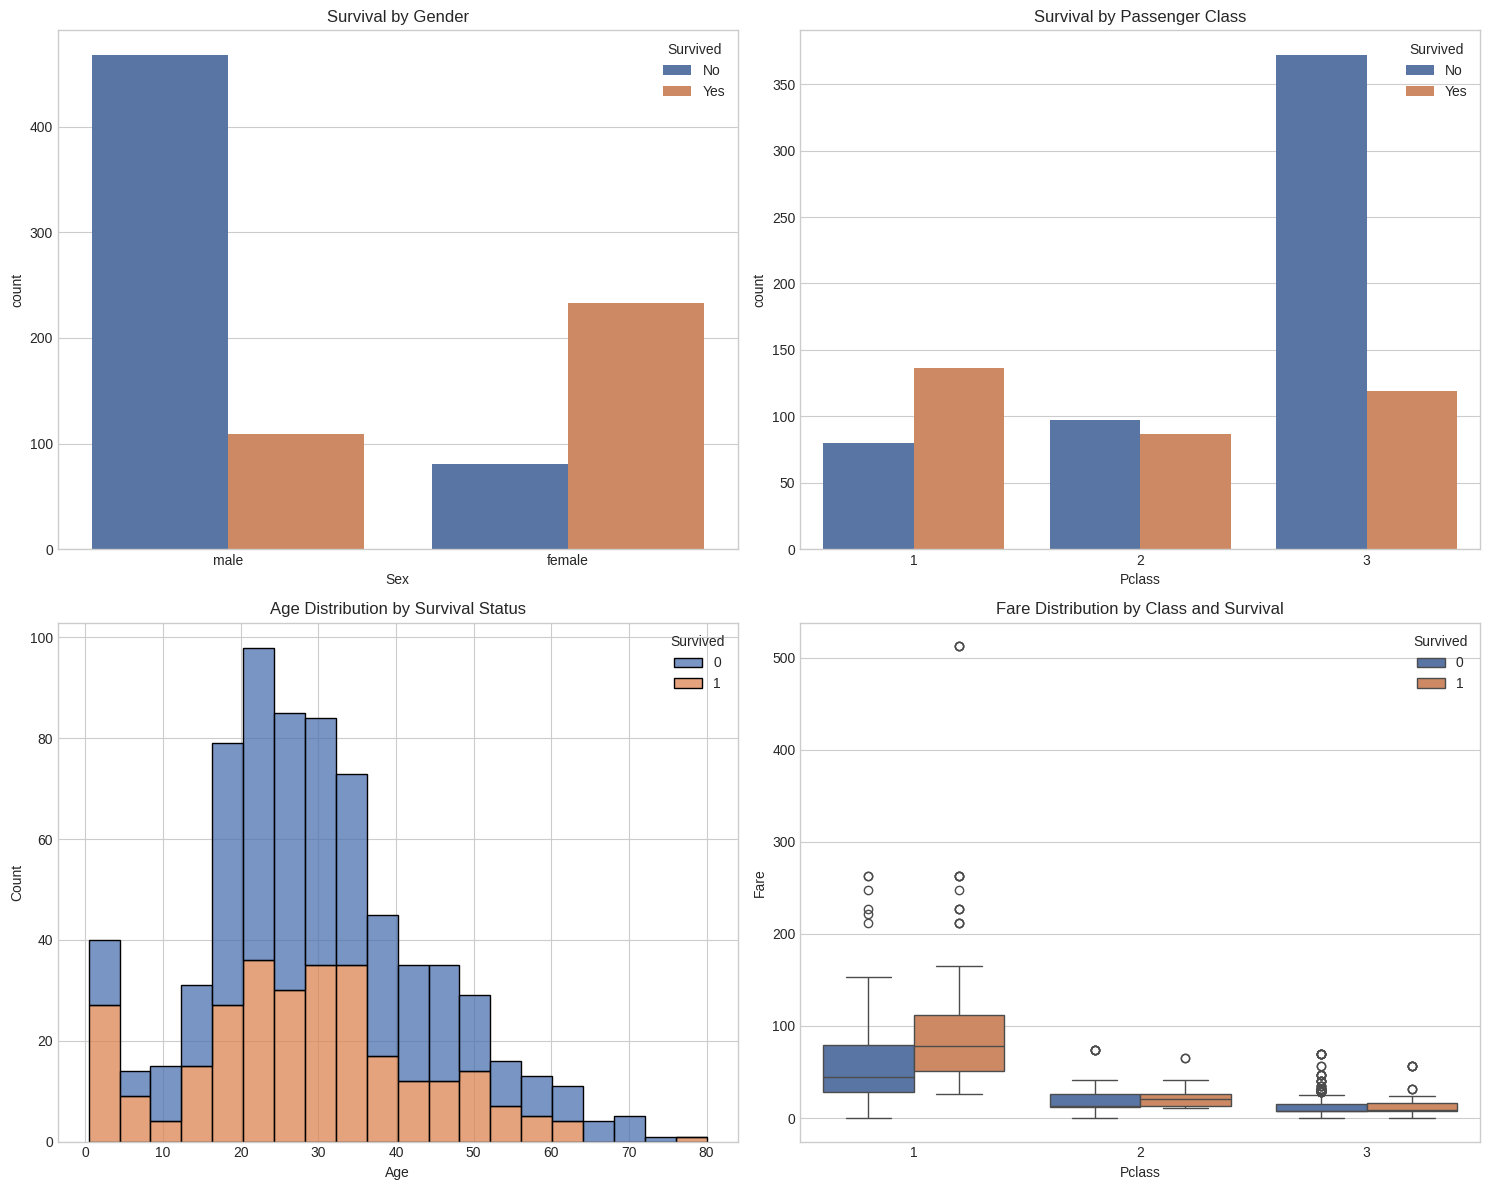

<ipython-input-7-8dfdf36703b2>:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], x='FamilySize', y='Survived', data=df, ci=None)


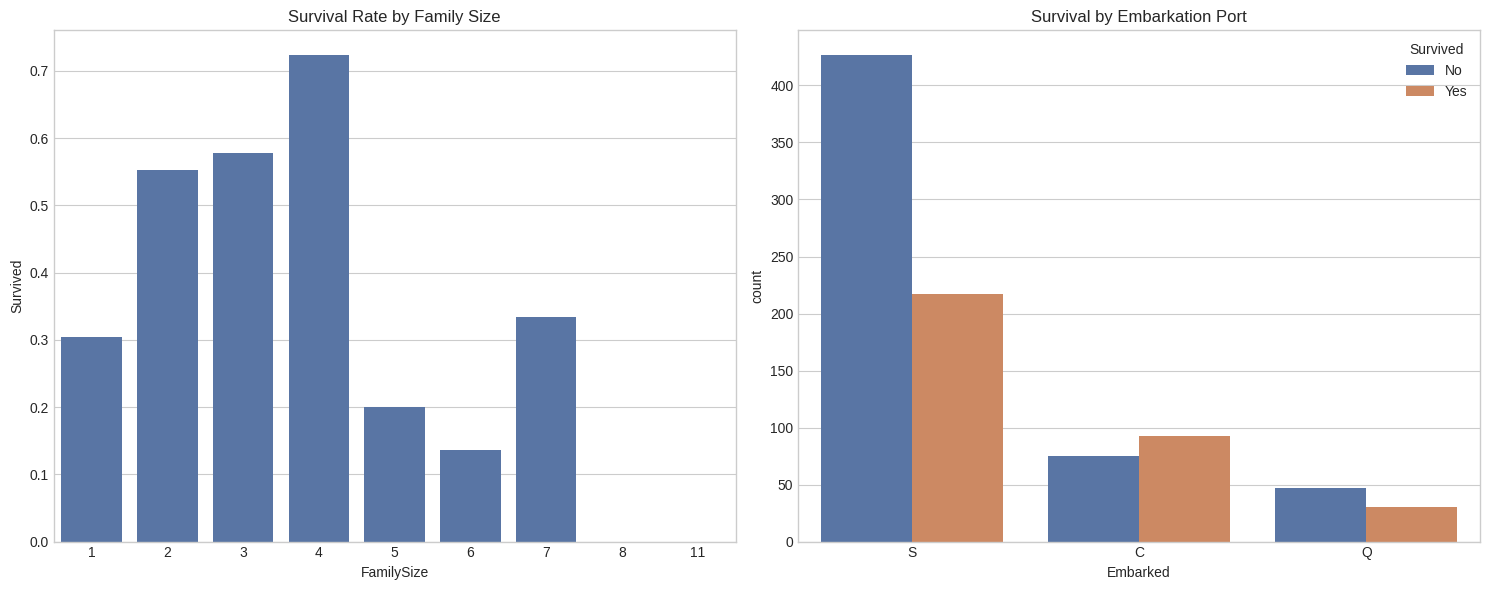


=== DATA PREPARATION ===

New features created:
- IsAlone
- Title
- AgeGroup
- FareCategory
- HasCabin
- Embarked_Class

Training set size: 712 samples
Validation set size: 179 samples

=== MODEL BUILDING ===
Numeric features: ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'HasCabin']
Categorical features: ['Pclass', 'Sex', 'Embarked', 'Title', 'AgeGroup', 'FareCategory', 'Embarked_Class']

Training model with grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

=== MODEL EVALUATION ===
Model Accuracy: 83.24%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.83      0.83  

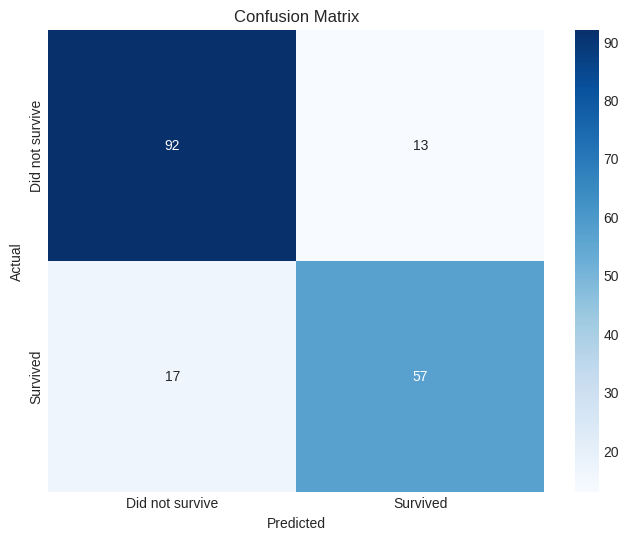

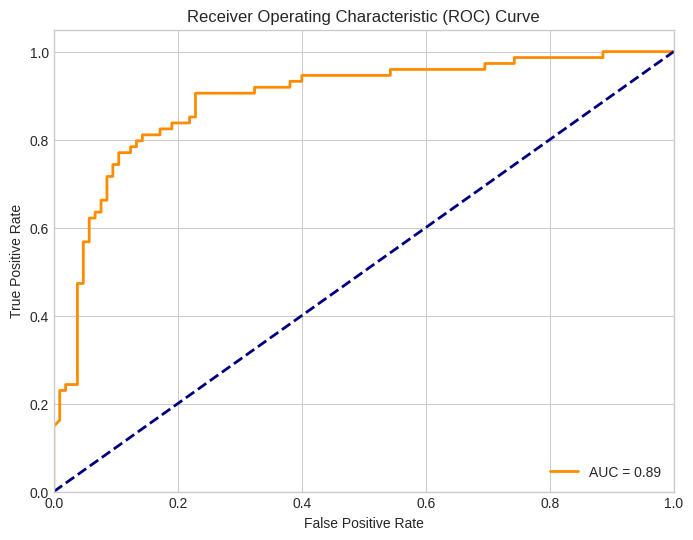


=== FEATURE IMPORTANCE ===


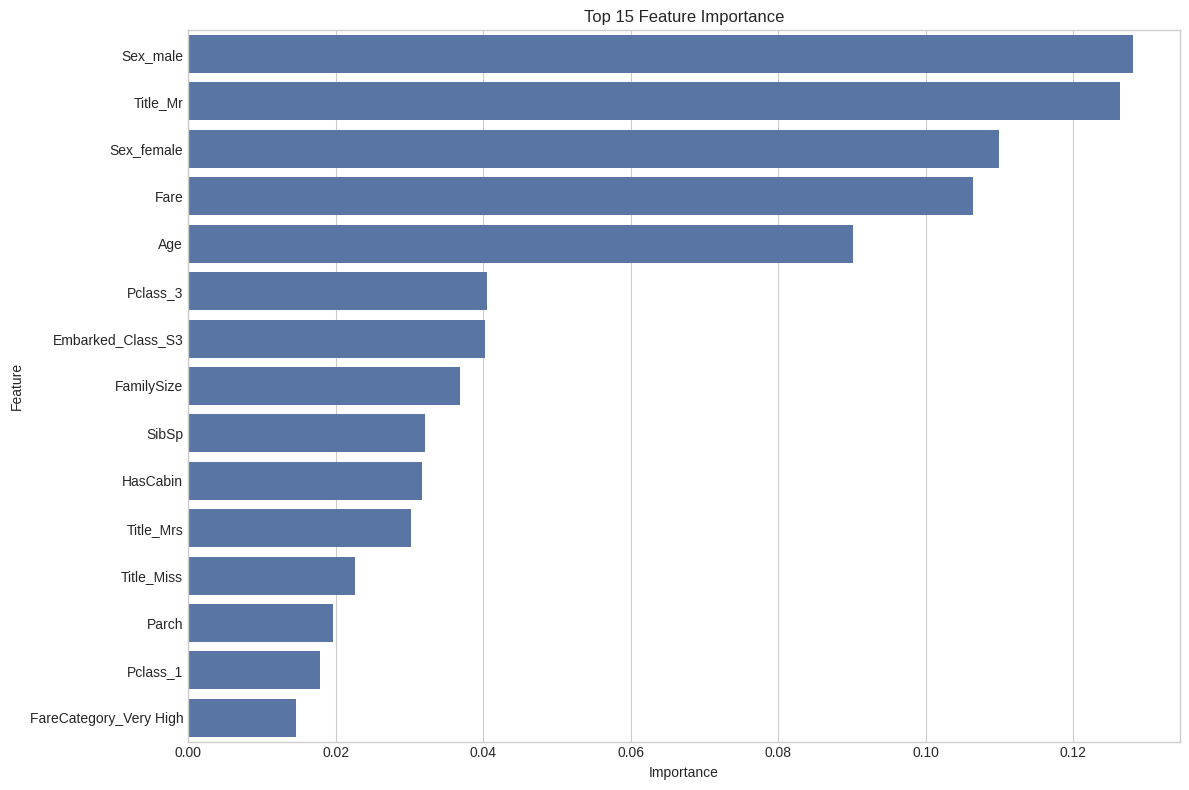


Top 10 most important features:


,Feature,Importance
11,Sex_male,0.128039
17,Title_Mr,0.126358
10,Sex_female,0.109949
3,Fare,0.106445
0,Age,0.090188
9,Pclass_3,0.040508
37,Embarked_Class_S3,0.040200
4,FamilySize,0.036916
1,SibSp,0.032071
6,HasCabin,0.031750



Predicting survival for sample passengers:

=== PREDICTION FOR NEW PASSENGERS ===

Prediction Results:


,Passenger,Prediction,Survival Probability
0,1,Survived,98.63%
1,2,Did not survive,7.99%
2,3,Survived,90.89%



Analysis complete!


In [25]:
def main():
    """Main function to run the Titanic survival prediction analysis"""
    print("=== TITANIC SURVIVAL PREDICTION ===")

    # Load data
    try:
        # Try to load from uploaded file
        from google.colab import files
        uploaded = files.upload()

        # Get the filename
        filename = list(uploaded.keys())[0]
        df = load_data(filename)
    except:
        print("Failed to upload file. Please provide a valid filepath")
        return

    if df is None:
        print("Failed to load data. Exiting.")
        return

    # Explore data
    df = explore_data(df)

    # Visualize data
    visualize_data(df)

    # Prepare data
    X_train, X_val, y_train, y_val, features = prepare_data(df)

    # Build model
    model = build_model(X_train, y_train, features)

    # Evaluate model
    accuracy = evaluate_model(model, X_val, y_val)

    # Show feature importance
    show_feature_importance(model, features)

    # Example: Make predictions on new data
    print("\nPredicting survival for sample passengers:")
    sample_passengers = pd.DataFrame({
        'Pclass': [1, 3, 2],
        'Sex': ['female', 'male', 'female'],
        'Age': [28, 24, 5],
        'SibSp': [0, 0, 1],
        'Parch': [0, 0, 2],
        'Fare': [80, 8, 30],
        'Embarked': ['C', 'S', 'Q'],
        'Name': ['Johnson, Mrs. Oscar', 'Smith, Mr. John', 'Williams, Miss. Anna'],
        'Ticket': ['PC 17755', 'A/5 2466', '23478'],
        'Cabin': [np.nan, np.nan, np.nan],
        'PassengerId': [1, 2, 3]
    })

    predict_survival(model, sample_passengers)

    print("\nAnalysis complete!")

# Run the analysis
if __name__ == "__main__":
    main()